In [1]:
import sys,os,re
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

os.environ['PYTHONPATH']=os.environ.get('SRC')
if not os.environ.get('SRC') in sys.path: 
    sys.path.insert(0,os.environ.get('SRC'))

%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline


import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import seaborn as sns
from scipy import stats
from box import Box
import warnings

from IPython.core.display import display, HTML

warnings.simplefilter('ignore')

D1 = os.environ.get('DAT')+'/helman-2019/'
FIG_DIR = os.environ.get('FIG')

Populating the interactive namespace from numpy and matplotlib


# Point of Departure (POD) Estimation: Acute toxicity

We demonstrate the application of genra-py for POD estimation, which is the determination of a dose  resulting in a toxicological effect ($\beta$) using descriptors ($\bf{x}^\alpha$): chemical ($\alpha$=chm). Complete details about the source of these data are described in the Methods section of our prior publication [Transitioning the generalised read-across approach (GenRA) to quantitative predictions: A case study using acute oral toxicity data](https://doi.org/10.1016/j.comtox.2019.100097).  

    

# System information
https://www.thepythoncode.com/article/get-hardware-system-information-python#CPU_info

In [14]:
def get_size(bytes, suffix="B"):
    """
    Scale bytes to its proper format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
        
import platform,psutil
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")
print("="*40, "CPU Info", "="*40)
# number of cores
print("Physical cores:", psutil.cpu_count(logical=False))
print("Total cores:", psutil.cpu_count(logical=True))
# CPU frequencies
cpufreq = psutil.cpu_freq()
print(f"Max Frequency: {cpufreq.max:.2f}Mhz")
print(f"Min Frequency: {cpufreq.min:.2f}Mhz")
print(f"Current Frequency: {cpufreq.current:.2f}Mhz")
# CPU usage
# print("CPU Usage Per Core:")
# for i, percentage in enumerate(psutil.cpu_percent(percpu=True, interval=1)):
#     print(f"Core {i}: {percentage}%")
print(f"Total CPU Usage: {psutil.cpu_percent()}%")
# Memory Information
print("="*40, "Memory Information", "="*40)
# get the memory details
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}")
print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}")
print(f"Percentage: {svmem.percent}%")
print("="*20, "SWAP", "="*20)
# get the swap memory details (if exists)
swap = psutil.swap_memory()
print(f"Total: {get_size(swap.total)}")
print(f"Free: {get_size(swap.free)}")
print(f"Used: {get_size(swap.used)}")
print(f"Percentage: {swap.percent}%")

System: Linux
Node Name: galaxy
Release: 5.8.0-44-generic
Version: #50~20.04.1-Ubuntu SMP Wed Feb 10 21:07:30 UTC 2021
Machine: x86_64
Processor: x86_64
======================================== CPU Info ========================================
Physical cores: 8
Total cores: 16
Max Frequency: 3700.00Mhz
Min Frequency: 1200.00Mhz
Current Frequency: 1304.29Mhz
Total CPU Usage: 1.7%
======================================== Memory Information ========================================
Total: 125.83GB
Available: 58.91GB
Used: 65.48GB
Percentage: 53.2%
==================== SWAP ====================
Total: 240.42GB
Free: 240.42GB
Used: 0.00B
Percentage: 0.0%


# Data 

## Supplemental Material

The data files were downloaded from the [supplemental material zip file](https://ars.els-cdn.com/content/image/1-s2.0-S2468111319300271-mmc1.zip)  (Helman  et al 2019) and extracted it in the [data/helman-2019](data/helman-2019) folder. These data files were loaded into pandas dataframes for further analysis. We used the unique DSSTox chemical substance identifier for each chemical. 

### Chemical data 
$\bf{x}^{chm}$



In [2]:
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs

In [3]:
xls0 = pd.ExcelFile(D1+'smi_acute.xlsx')
CHM0 = pd.concat([xls0.parse('first'),xls0.parse('last')], axis = 0)\
         .drop(['INPUT','FOUND_BY'],axis=1)
CHM0 = CHM0[CHM0["SMILES"]!='-']
MOLS = dict(zip(CHM0['DTXSID'], CHM0['SMILES']))
MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
MOLS = {i:j for i,j in MOLS.items() if j}
FP0 = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,1024)) for i in MOLS.values()])
FP0.index=MOLS.keys()
FP0.columns = ['mrgn_%d'%i for i in FP0.columns]
#FP1.head()

RDKit ERROR: [12:08:56] Explicit valence for atom # 3 O, 3, is greater than permitted


### POD Data: $LD_{50}$ values

<AxesSubplot:>

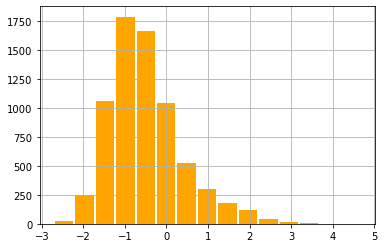

In [4]:
POD0 = pd.read_csv(D1+'small_acute_processed.csv').set_index('dsstox_sid')
POD0.LD50_LM.hist(bins=15,rwidth=0.9,color='orange')

### Make sure we have structure data for chemicals

In [6]:
I = FP0.index.intersection(POD0.index)
X,Y = FP0.loc[I],POD0.loc[I,'LD50_LM']

# GenRA Analysis



## Find optimal value of k 

Conduct a grid search to identify the optimal value of $k$ for estimating $LD_{50}$ values.  

In [7]:
from genra.rax.skl.reg import GenRAPredValue
from sklearn.metrics import make_scorer,explained_variance_score,roc_auc_score,r2_score,f1_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

#KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
#                     metric=’minkowski’, metric_params=None, n_jobs=1)[source]

GP1 = GenRAPredValue(algorithm='brute')

params={'n_neighbors': range(1,15),
        'metric':['jaccard','euclidean']
       }


Grid3= GridSearchCV(estimator=GP1,param_grid=params,
                    n_jobs=-1,cv=5,
                    verbose=1,
                    scoring=make_scorer(r2_score))


Best3=Grid3.fit(X,Y)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   43.1s finished


Best: 0.4281329280846897 {'metric': 'jaccard', 'n_neighbors': 8}


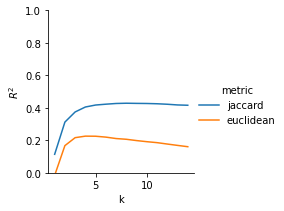

In [8]:
P = pd.DataFrame(Best3.cv_results_['params'])
P.insert(2,'score_mn',Best3.cv_results_['mean_test_score'])
P.insert(3,'score_std',Best3.cv_results_['std_test_score'])

g=sns.FacetGrid(P,hue='metric')
g.map(pl.plot,'n_neighbors','score_mn')
g.set(ylim=(0,1.0),xlabel='k',ylabel='$R^2$')
g.add_legend()
print("Best:", Best3.best_score_,Best3.best_params_)

## Estimate POD based on optimal choice

In [9]:
from sklearn.model_selection import cross_val_predict,LeaveOneOut
from genra.rax.skl.reg import *


GC1 = GenRAPredValue(n_neighbors=8,algorithm='brute',metric='jaccard',n_jobs=-1)

Loo = LeaveOneOut()
Loo.get_n_splits(X)

Yp = cross_val_predict(GC1,X,Y,cv=LeaveOneOut(),n_jobs=-1,verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 4804 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 6304 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 6944 out of 6975 | elapsed:  1.0min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 6975 out of 6975 | elapsed:  1.0min finished


In [10]:
Perf1 = pd.DataFrame(dict(Y_true=Y,Y_pred=Yp))


### Performance summary

In [11]:
print("$R^2$ score= {:.3f}\nRMSE={:0.3f}\n"\
              .format(r2_score(Perf1['Y_true'],Perf1['Y_pred']),
                      np.sqrt(((Perf1['Y_true']-Perf1['Y_pred'])**2).mean())))
      

$R^2$ score= 0.517
RMSE=0.613



In [29]:
Perf1['residual']=(Perf1['Y_pred']-Perf1['Y_true'])
Perf1['mse']=(Perf1['Y_true']-Perf1['Y_pred'])**2

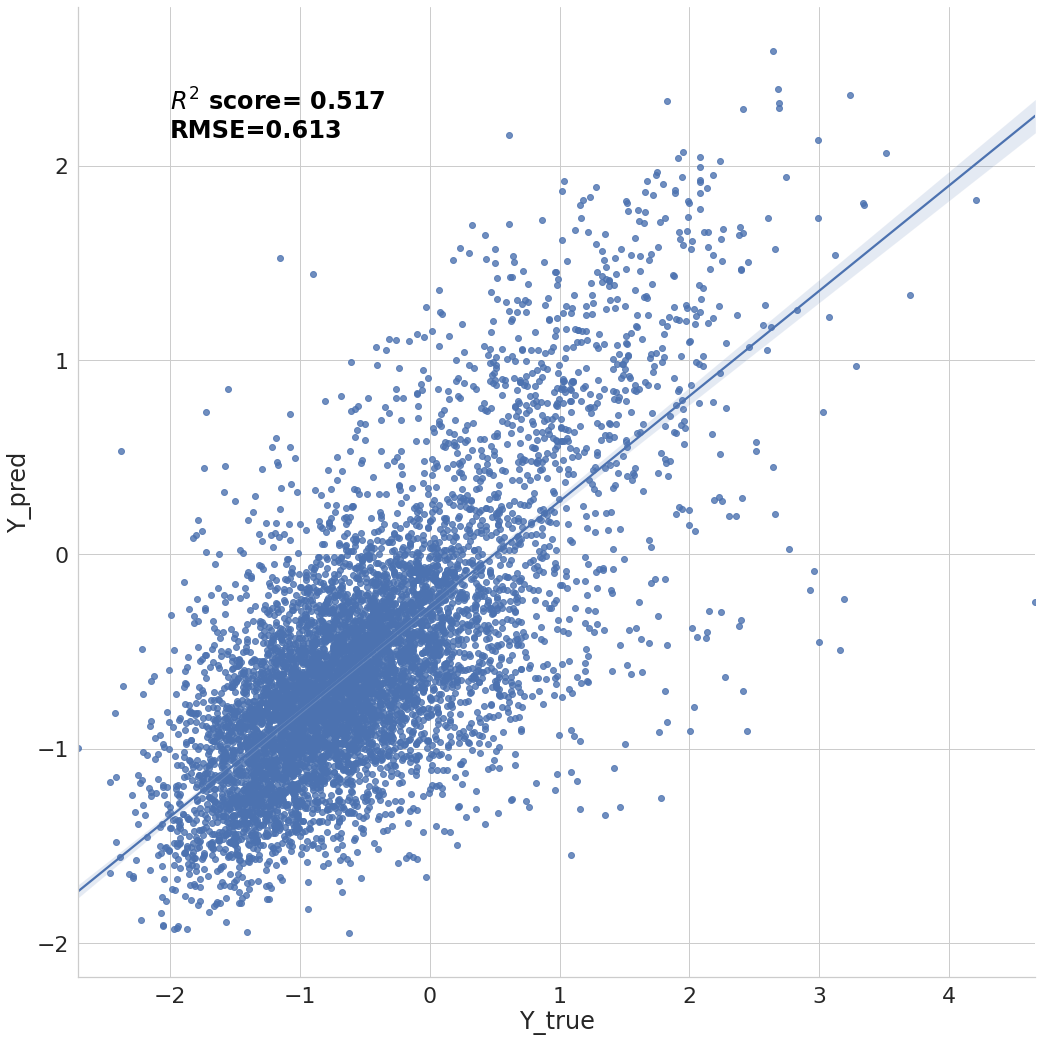

In [47]:
import seaborn as sns

sns.set(style='whitegrid',font_scale=2.0)

g=sns.lmplot(x='Y_true',y='Y_pred',data=Perf1,height=15,aspect=1.0)
txt = "$R^2$ score= {:.3f}\nRMSE={:0.3f}\n"\
              .format(r2_score(Perf1['Y_true'],Perf1['Y_pred']),
                      np.sqrt(((Perf1['Y_true']-Perf1['Y_pred'])**2).mean()))
 

for p in g.axes:
    p[0].text(-2, 2, txt, horizontalalignment='left', size='medium', color='black', weight='semibold')


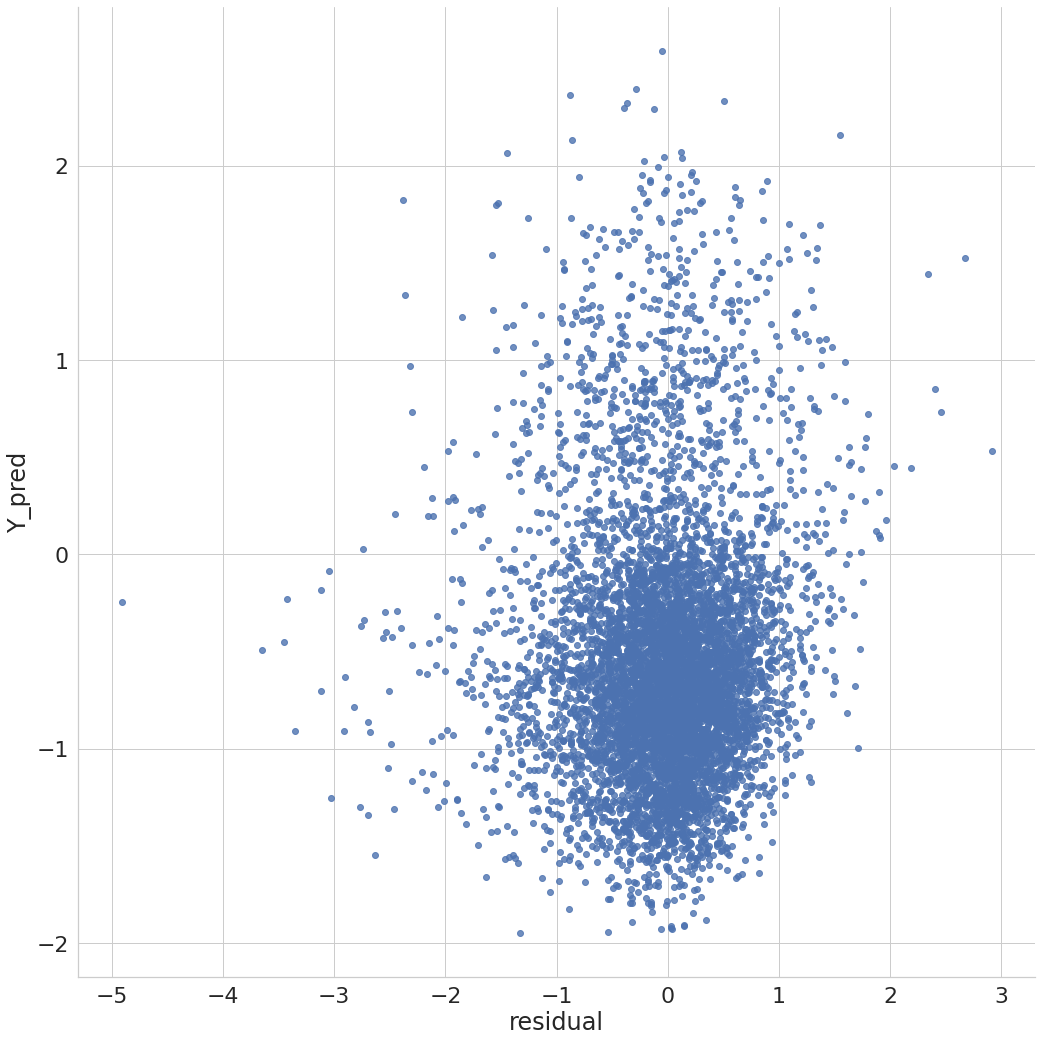

In [51]:
import seaborn as sns

sns.set(style='whitegrid',font_scale=2.0)

g=sns.lmplot(x='residual',y='Y_pred',data=Perf1,height=15,aspect=1.0,fit_reg=False)

